# Crime data cleaning

## We start by importing the packages

In [1]:
import pandas as pd
import pylab as pl
import urllib.request
from urllib.request import urlretrieve
import zipfile
import geopandas as gp
from shapely.geometry import Point, LineString

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load the Crime Data from NYPD (Last download made in July 2018)

In [2]:
crime = pd.read_csv("NYPD_Complaint_Data_Historic.csv")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
crime.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"
3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,105.0,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,13.0,FRONT OF,OTHER,NaN,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)"


In [4]:
crime.OFNS_DESC.unique()

array(['FORGERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'DANGEROUS DRUGS',
       'ASSAULT 3 & RELATED OFFENSES', 'FELONY ASSAULT',
       'DANGEROUS WEAPONS', 'PETIT LARCENY', 'GRAND LARCENY', 'ROBBERY',
       'OFFENSES AGAINST PUBLIC ADMINI', 'CRIMINAL MISCHIEF & RELATED OF',
       'RAPE', 'INTOXICATED & IMPAIRED DRIVING', 'HARRASSMENT 2',
       'SEX CRIMES', 'BURGLARY', 'CRIMINAL TRESPASS',
       'MISCELLANEOUS PENAL LAW', 'VEHICLE AND TRAFFIC LAWS',
       'OFF. AGNST PUB ORD SENSBLTY &', 'FRAUDS',
       'GRAND LARCENY OF MOTOR VEHICLE', 'OFFENSES INVOLVING FRAUD',
       'OFFENSES AGAINST THE PERSON', 'FRAUDULENT ACCOSTING',
       'OTHER OFFENSES RELATED TO THEF', 'GAMBLING', 'ARSON',
       'POSSESSION OF STOLEN PROPERTY', 'UNAUTHORIZED USE OF A VEHICLE',
       'THEFT-FRAUD', 'DISORDERLY CONDUCT', nan, 'ADMINISTRATIVE CODE',
       'CHILD ABANDONMENT/NON SUPPORT', 'OTHER STATE LAWS (NON PENAL LA',
       'NYS LAWS-UNCLASSIFIED FELONY', "BURGLAR'S TOOLS",
       'THEFT OF SERV

# We filter just the types of crime that we consider relevant (This is supported in literature, refer to the paper)

In [5]:
robbery = crime[crime["OFNS_DESC"]=='ROBBERY']
petit_larceny = crime[crime["OFNS_DESC"]=='PETIT LARCENY']
drugs = crime[crime["OFNS_DESC"]=='DANGEROUS DRUGS']


In [6]:
robbery.columns = petit_larceny.columns
df = pd.concat([robbery, petit_larceny])

In [7]:
print (robbery.shape)
print (petit_larceny.shape)
print (drugs.shape)


(228220, 24)
(987326, 24)
(392992, 24)


In [8]:
df.columns = drugs.columns

df = pd.concat([df, drugs])

In [9]:
df.shape

(1608538, 24)

In [10]:
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
15,715942154,12/31/2015,23:00:00,12/31/2015,23:05:00,12/31/2015,105,ROBBERY,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",...,103.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1044662.0,197327.0,40.708096,-73.782102,"(40.708095777, -73.78210174)"
40,221366121,12/31/2015,22:20:00,12/31/2015,22:30:00,12/31/2015,105,ROBBERY,399.0,"ROBBERY,COMMERCIAL UNCLASSIFIED",...,72.0,INSIDE,GAS STATION,NaN,NaN,978339.0,174226.0,40.644893,-74.021302,"(40.64489299, -74.021301578)"
44,492283167,12/31/2015,22:15:00,NaN,NaN,12/31/2015,105,ROBBERY,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",...,81.0,FRONT OF,RESIDENCE - APT. HOUSE,NaN,NaN,1005570.0,186646.0,40.678959,-73.923136,"(40.678959455, -73.923136122)"
130,900249555,12/31/2015,19:25:00,12/31/2015,20:00:00,12/31/2015,105,ROBBERY,388.0,"ROBBERY,RESIDENTIAL COMMON AREA",...,43.0,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,SOUNDVIEW,1020891.0,236726.0,40.816366,-73.867626,"(40.816366145, -73.867626311)"
144,312237740,12/31/2015,19:07:00,12/31/2015,19:13:00,12/31/2015,105,ROBBERY,377.0,"ROBBERY,BODEGA/CONVENIENCE STORE",...,69.0,INSIDE,GROCERY/BODEGA,NaN,NaN,1013358.0,170146.0,40.633648,-73.895129,"(40.633648412, -73.895129166)"


In [11]:
type(df.CMPLNT_FR_DT.iloc[1])

str

# Eliminate some wierd records

In [12]:
df = df[df['CMPLNT_FR_DT'] != "10/27/1015"]
df = df[df['CMPLNT_FR_DT'] != "09/19/1026"]
df = df[df['CMPLNT_FR_DT'] != "09/08/1016"]
df = df[df['CMPLNT_FR_DT'] != "08/10/1016"]
df = df[df['CMPLNT_FR_DT'] != "04/06/1016"]
df = df[df['CMPLNT_FR_DT'] != "05/09/1016"]
df = df[df['CMPLNT_FR_DT'] != "02/08/1015"]
df = df[df['CMPLNT_FR_DT'] != "01/29/1026"]
df = df[df['CMPLNT_FR_DT'] != "11/20/1015"]
df = df[df['CMPLNT_FR_DT'] != "11/29/1027"]
df = df[df['CMPLNT_FR_DT'] != "05/28/1027"]
df = df[df['CMPLNT_FR_DT'] != "06/09/1017"]
df = df[df['CMPLNT_FR_DT'] != "05/05/1017"]
df = df[df['CMPLNT_FR_DT'] != "04/11/1017"]
df = df[df['CMPLNT_FR_DT'] != "04/05/1017"]
df = df[df['CMPLNT_FR_DT'] != "06/02/1017"]

In [13]:
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'])

# We are only interested in crimes between 2013 and 2017

In [14]:
df = df[df["CMPLNT_FR_DT"]>'12/31/2012']
df = df[df["CMPLNT_FR_DT"]<'01/01/2018']

In [15]:
df.shape

(623492, 24)

# To calculate the change rate between 2013 and 2017 we calculate the number of crimes commited in each year

In [16]:
df_2013 = df[df["CMPLNT_FR_DT"]<'01/01/2014']
df_2017 = df[df["CMPLNT_FR_DT"]>'12/31/2016']

In [17]:
print (df_2013.shape)
print (df_2017.shape)

(133721, 24)
(117743, 24)


# load Zip Code Data

In [18]:
zipcodes = gp.GeoDataFrame.from_file("ZIP_CODE_040114.shp")

In [19]:
zipcodes = zipcodes.to_crs(epsg=4326)

In [20]:
zipcodes = zipcodes[['ZIPCODE', 'geometry']]

# Assign each crime to a Zip Code

In [21]:
crime = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
crime2013 = [Point(xy) for xy in zip(df_2013.Longitude, df_2013.Latitude)]
crime2017 = [Point(xy) for xy in zip(df_2017.Longitude, df_2017.Latitude)]

In [22]:
crs = {"init" : "epsg:4326"}

In [23]:
crime_gdf = gp.GeoDataFrame(df, geometry = crime, crs=crs) 
crime2013_gdf = gp.GeoDataFrame(df_2013, geometry = crime2013, crs=crs) 
crime2017_gdf = gp.GeoDataFrame(df_2017, geometry = crime2017, crs=crs) 

In [24]:
crime_gdf.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,geometry
15,715942154,2015-12-31,23:00:00,12/31/2015,23:05:00,12/31/2015,105,ROBBERY,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",...,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1044662.0,197327.0,40.708096,-73.782102,"(40.708095777, -73.78210174)",POINT (-73.78210174 40.708095777)
40,221366121,2015-12-31,22:20:00,12/31/2015,22:30:00,12/31/2015,105,ROBBERY,399.0,"ROBBERY,COMMERCIAL UNCLASSIFIED",...,INSIDE,GAS STATION,NaN,NaN,978339.0,174226.0,40.644893,-74.021302,"(40.64489299, -74.021301578)",POINT (-74.02130157800001 40.64489299)
44,492283167,2015-12-31,22:15:00,NaN,NaN,12/31/2015,105,ROBBERY,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",...,FRONT OF,RESIDENCE - APT. HOUSE,NaN,NaN,1005570.0,186646.0,40.678959,-73.923136,"(40.678959455, -73.923136122)",POINT (-73.923136122 40.678959455)
130,900249555,2015-12-31,19:25:00,12/31/2015,20:00:00,12/31/2015,105,ROBBERY,388.0,"ROBBERY,RESIDENTIAL COMMON AREA",...,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,SOUNDVIEW,1020891.0,236726.0,40.816366,-73.867626,"(40.816366145, -73.867626311)",POINT (-73.86762631100001 40.816366145)
144,312237740,2015-12-31,19:07:00,12/31/2015,19:13:00,12/31/2015,105,ROBBERY,377.0,"ROBBERY,BODEGA/CONVENIENCE STORE",...,INSIDE,GROCERY/BODEGA,NaN,NaN,1013358.0,170146.0,40.633648,-73.895129,"(40.633648412, -73.895129166)",POINT (-73.895129166 40.633648412)


In [25]:
crime_gdf.shape

(623492, 25)

In [26]:
zipcodes.head()

,ZIPCODE,geometry
0,11436,POLYGON ((-73.80584847647394 40.68290932644247...
1,11213,POLYGON ((-73.93739763139813 40.67972958925081...
2,11212,POLYGON ((-73.90294132545438 40.67083977590008...
3,11225,POLYGON ((-73.95797316043482 40.67065695897566...
4,11218,POLYGON ((-73.97208109564257 40.65059658727608...


In [27]:
zipcodes.shape

(263, 2)

In [28]:
crime_gdf = gp.sjoin(crime_gdf, zipcodes, how = "right", op="within").reset_index()

In [29]:
crime_gdf.shape

(614539, 28)

In [30]:
#crime_gdf.to_csv('crimes.csv')

In [31]:
crime_gdf.head()

,index_right,index_left,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,...,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,ZIPCODE,geometry
0,0,5671853.0,706726833.0,2017-10-19,08:00:00,10/19/2017,14:00:00,10/19/2017,341.0,PETIT LARCENY,...,RESIDENCE-HOUSE,NaN,NaN,1041339.0,188992.0,40.68524,-73.794158,"(40.685240262, -73.794158048)",11436,POLYGON ((-73.80584847647394 40.68290932644247...
1,0,186179.0,404695072.0,2015-08-14,14:00:00,NaN,NaN,08/14/2015,341.0,PETIT LARCENY,...,RESIDENCE-HOUSE,NaN,NaN,1041339.0,188992.0,40.68524,-73.794158,"(40.685240262, -73.794158048)",11436,POLYGON ((-73.80584847647394 40.68290932644247...
2,0,348162.0,253378317.0,2015-04-17,22:29:00,NaN,NaN,04/21/2015,341.0,PETIT LARCENY,...,RESIDENCE-HOUSE,NaN,NaN,1041339.0,188992.0,40.68524,-73.794158,"(40.685240262, -73.794158048)",11436,POLYGON ((-73.80584847647394 40.68290932644247...
3,0,5136171.0,187667653.0,2016-12-02,16:08:00,12/02/2016,20:35:00,12/03/2016,341.0,PETIT LARCENY,...,RESIDENCE - APT. HOUSE,NaN,NaN,1041339.0,188992.0,40.68524,-73.794158,"(40.685240262, -73.794158048)",11436,POLYGON ((-73.80584847647394 40.68290932644247...
4,0,5178384.0,370949719.0,2016-10-30,17:30:00,10/30/2016,17:35:00,10/30/2016,105.0,ROBBERY,...,STREET,NaN,NaN,1041339.0,188992.0,40.68524,-73.794158,"(40.685240262, -73.794158048)",11436,POLYGON ((-73.80584847647394 40.68290932644247...


# Count number of crimes by Zip Code

In [32]:
countzip = crime_gdf.groupby(crime_gdf["ZIPCODE"]).count()

In [33]:
countzip.shape

(248, 27)

In [34]:
countzip.head()

,index_right,index_left,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,geometry
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
00083,840,840,840,840,840,723,723,840,840,840,...,331,833,320,0,840,840,840,840,840,840
10001,14550,14550,14550,14550,14550,8872,8872,14550,14550,14550,...,13459,14481,38,0,14550,14550,14550,14550,14550,14550
10002,6910,6910,6910,6910,6910,5993,5999,6910,6910,6910,...,5765,6896,157,1087,6910,6910,6910,6910,6910,6910
10003,9562,9562,9562,9562,9562,7743,7747,9562,9562,9562,...,8488,9406,95,0,9562,9562,9562,9562,9562,9562
10004,825,824,824,824,824,744,745,824,824,824,...,704,813,22,0,824,824,824,824,824,825


# Lets count by year to calculate the differences

In [35]:
crime2013_gdf = gp.sjoin(crime2013_gdf, zipcodes, how = "right", op="within").reset_index()
crime2017_gdf = gp.sjoin(crime2017_gdf, zipcodes, how = "right", op="within").reset_index()

In [36]:
print (crime2013_gdf.shape)
print (crime2017_gdf.shape)

(129811, 28)
(117369, 28)


In [37]:
count2013 = crime2013_gdf.groupby(crime2013_gdf["ZIPCODE"]).count()
count2017 = crime2017_gdf.groupby(crime2017_gdf["ZIPCODE"]).count()

In [38]:
print (count2013.shape)
print (count2017.shape)

(248, 27)
(248, 27)


In [39]:
count2013.head(2)

,index_right,index_left,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,geometry
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
00083,171,171,171,171,171,150,150,171,171,171,...,74,169,0,0,171,171,171,171,171,171
10001,3758,3758,3758,3758,3758,2379,2379,3758,3758,3758,...,3527,3739,0,0,3758,3758,3758,3758,3758,3758


In [40]:
countzip["Absolute_Difference"] = count2017.geometry - count2013.geometry
countzip["Percentual_Difference"] = (count2017.geometry - count2013.geometry) / count2013.geometry

In [41]:
countzip.head()

,index_right,index_left,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,...,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,geometry,Absolute_Difference,Percentual_Difference
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
00083,840,840,840,840,840,723,723,840,840,840,...,320,0,840,840,840,840,840,840,-20,-0.116959
10001,14550,14550,14550,14550,14550,8872,8872,14550,14550,14550,...,38,0,14550,14550,14550,14550,14550,14550,-1511,-0.402076
10002,6910,6910,6910,6910,6910,5993,5999,6910,6910,6910,...,157,1087,6910,6910,6910,6910,6910,6910,74,0.055723
10003,9562,9562,9562,9562,9562,7743,7747,9562,9562,9562,...,95,0,9562,9562,9562,9562,9562,9562,-484,-0.222426
10004,825,824,824,824,824,744,745,824,824,824,...,22,0,824,824,824,824,824,825,102,0.790698


In [42]:
countzip.head()

,index_right,index_left,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,...,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,geometry,Absolute_Difference,Percentual_Difference
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
00083,840,840,840,840,840,723,723,840,840,840,...,320,0,840,840,840,840,840,840,-20,-0.116959
10001,14550,14550,14550,14550,14550,8872,8872,14550,14550,14550,...,38,0,14550,14550,14550,14550,14550,14550,-1511,-0.402076
10002,6910,6910,6910,6910,6910,5993,5999,6910,6910,6910,...,157,1087,6910,6910,6910,6910,6910,6910,74,0.055723
10003,9562,9562,9562,9562,9562,7743,7747,9562,9562,9562,...,95,0,9562,9562,9562,9562,9562,9562,-484,-0.222426
10004,825,824,824,824,824,744,745,824,824,824,...,22,0,824,824,824,824,824,825,102,0.790698


In [43]:
countzip['ZIPCODE'] = countzip.index

In [44]:
countzip.head()

,index_right,index_left,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,...,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,geometry,Absolute_Difference,Percentual_Difference,ZIPCODE
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
00083,840,840,840,840,840,723,723,840,840,840,...,0,840,840,840,840,840,840,-20,-0.116959,00083
10001,14550,14550,14550,14550,14550,8872,8872,14550,14550,14550,...,0,14550,14550,14550,14550,14550,14550,-1511,-0.402076,10001
10002,6910,6910,6910,6910,6910,5993,5999,6910,6910,6910,...,1087,6910,6910,6910,6910,6910,6910,74,0.055723,10002
10003,9562,9562,9562,9562,9562,7743,7747,9562,9562,9562,...,0,9562,9562,9562,9562,9562,9562,-484,-0.222426,10003
10004,825,824,824,824,824,744,745,824,824,824,...,0,824,824,824,824,824,825,102,0.790698,10004


In [45]:
crime_final = countzip[["Absolute_Difference", "Percentual_Difference", "ZIPCODE"]]

In [46]:
crime_final.head()

,Absolute_Difference,Percentual_Difference,ZIPCODE
ZIPCODE,,,
00083,-20,-0.116959,00083
10001,-1511,-0.402076,10001
10002,74,0.055723,10002
10003,-484,-0.222426,10003
10004,102,0.790698,10004


In [47]:
crime_final.to_csv('crime.csv')

In [48]:
crime_final.Absolute_Difference.describe()

count     248.000000
mean      -50.169355
std       159.896157
min     -1511.000000
25%       -74.000000
50%         0.000000
75%         5.000000
max       295.000000
Name: Absolute_Difference, dtype: float64

In [49]:
crime_final.Percentual_Difference.describe()

count    248.000000
mean       0.004625
std        0.441285
min       -0.800000
25%       -0.169992
50%        0.000000
75%        0.033905
max        4.333333
Name: Percentual_Difference, dtype: float64

(array([   2.,    3.,   19.,   59.,  109.,   39.,    4.,    3.,    1.,
           2.,    1.,    0.,    0.,    2.,    0.,    0.,    2.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.]),
 array([-0.8       , -0.62888889, -0.45777778, -0.28666667, -0.11555556,
         0.05555556,  0.22666667,  0.39777778,  0.56888889,  0.74      ,
         0.91111111,  1.08222222,  1.25333333,  1.42444444,  1.59555556,
         1.76666667,  1.93777778,  2.10888889,  2.28      ,  2.45111111,
         2.62222222,  2.79333333,  2.96444444,  3.13555556,  3.30666667,
         3.47777778,  3.64888889,  3.82      ,  3.99111111,  4.16222222,
         4.33333333]),
 <a list of 30 Patch objects>)

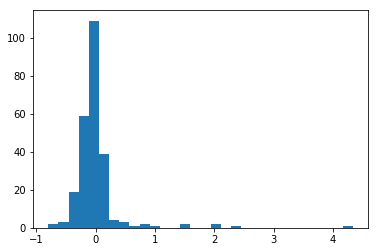

In [50]:
pl.hist(crime_final.Percentual_Difference, bins = 30)

# Now, instead of doing a comparisson for all the types of crime selected we separate by type of crime (The resulting data is the one incorporated in the final datset)

In [51]:
robbery = df[df["OFNS_DESC"]=='ROBBERY']
petit_larceny = df[df["OFNS_DESC"]=='PETIT LARCENY']
drugs = df[df["OFNS_DESC"]=='DANGEROUS DRUGS']

In [52]:
robbery.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,geometry
index_left,,,,,,,,,,,,,,,,,,,,,
15,715942154,2015-12-31,23:00:00,12/31/2015,23:05:00,12/31/2015,105,ROBBERY,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",...,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1044662.0,197327.0,40.708096,-73.782102,"(40.708095777, -73.78210174)",POINT (-73.78210174 40.708095777)
40,221366121,2015-12-31,22:20:00,12/31/2015,22:30:00,12/31/2015,105,ROBBERY,399.0,"ROBBERY,COMMERCIAL UNCLASSIFIED",...,INSIDE,GAS STATION,NaN,NaN,978339.0,174226.0,40.644893,-74.021302,"(40.64489299, -74.021301578)",POINT (-74.02130157800001 40.64489299)
44,492283167,2015-12-31,22:15:00,NaN,NaN,12/31/2015,105,ROBBERY,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",...,FRONT OF,RESIDENCE - APT. HOUSE,NaN,NaN,1005570.0,186646.0,40.678959,-73.923136,"(40.678959455, -73.923136122)",POINT (-73.923136122 40.678959455)
130,900249555,2015-12-31,19:25:00,12/31/2015,20:00:00,12/31/2015,105,ROBBERY,388.0,"ROBBERY,RESIDENTIAL COMMON AREA",...,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,SOUNDVIEW,1020891.0,236726.0,40.816366,-73.867626,"(40.816366145, -73.867626311)",POINT (-73.86762631100001 40.816366145)
144,312237740,2015-12-31,19:07:00,12/31/2015,19:13:00,12/31/2015,105,ROBBERY,377.0,"ROBBERY,BODEGA/CONVENIENCE STORE",...,INSIDE,GROCERY/BODEGA,NaN,NaN,1013358.0,170146.0,40.633648,-73.895129,"(40.633648412, -73.895129166)",POINT (-73.895129166 40.633648412)


In [53]:
print (robbery.shape)
print (petit_larceny.shape)
print (drugs.shape)

(82051, 25)
(415057, 25)
(126384, 25)


In [54]:
type(robbery.CMPLNT_FR_DT.iloc[1])

pandas.tslib.Timestamp

In [55]:
robbery_2013 = robbery[robbery["CMPLNT_FR_DT"]<'01/01/2014']
robbery_2014 = robbery[(robbery["CMPLNT_FR_DT"]>'12/31/2013') & (robbery["CMPLNT_FR_DT"]<'01/01/2015')]
robbery_2015 = robbery[(robbery["CMPLNT_FR_DT"]>'12/31/2014') & (robbery["CMPLNT_FR_DT"]<'01/01/2016')]
robbery_2016 = robbery[(robbery["CMPLNT_FR_DT"]>'12/31/2015') & (robbery["CMPLNT_FR_DT"]<'01/01/2017')]
robbery_2017 = robbery[robbery["CMPLNT_FR_DT"]>'12/31/2016']

petit_larceny_2013 = petit_larceny[petit_larceny["CMPLNT_FR_DT"]<'01/01/2014']
petit_larceny_2014 = petit_larceny[(petit_larceny["CMPLNT_FR_DT"]>'12/31/2013') & (petit_larceny["CMPLNT_FR_DT"]<'01/01/2015')]
petit_larceny_2015 = petit_larceny[(petit_larceny["CMPLNT_FR_DT"]>'12/31/2014') & (petit_larceny["CMPLNT_FR_DT"]<'01/01/2016')]
petit_larceny_2016 = petit_larceny[(petit_larceny["CMPLNT_FR_DT"]>'12/31/2015') & (petit_larceny["CMPLNT_FR_DT"]<'01/01/2017')]
petit_larceny_2017 = petit_larceny[petit_larceny["CMPLNT_FR_DT"]>'12/31/2016']

drugs_2013 = drugs[drugs["CMPLNT_FR_DT"]<'01/01/2014']
drugs_2014 = drugs[(drugs["CMPLNT_FR_DT"]>'12/31/2013') & (drugs["CMPLNT_FR_DT"]>'01/01/2015')]
drugs_2015 = drugs[(drugs["CMPLNT_FR_DT"]>'12/31/2014') & (drugs["CMPLNT_FR_DT"]>'01/01/2016')]
drugs_2016 = drugs[(drugs["CMPLNT_FR_DT"]>'12/31/2015') & (drugs["CMPLNT_FR_DT"]>'01/01/2017')]
drugs_2017 = drugs[drugs["CMPLNT_FR_DT"]>'12/31/2016']


In [56]:
robbery = [Point(xy) for xy in zip(robbery.Longitude, robbery.Latitude)]
robbery2013 = [Point(xy) for xy in zip(robbery_2013.Longitude, robbery_2013.Latitude)]
robbery2014 = [Point(xy) for xy in zip(robbery_2014.Longitude, robbery_2014.Latitude)]
robbery2015 = [Point(xy) for xy in zip(robbery_2015.Longitude, robbery_2015.Latitude)]
robbery2016 = [Point(xy) for xy in zip(robbery_2016.Longitude, robbery_2016.Latitude)]
robbery2017 = [Point(xy) for xy in zip(robbery_2017.Longitude, robbery_2017.Latitude)]

petit_larceny = [Point(xy) for xy in zip(petit_larceny.Longitude, petit_larceny.Latitude)]
petit_larceny2013 = [Point(xy) for xy in zip(petit_larceny_2013.Longitude, petit_larceny_2013.Latitude)]
petit_larceny2014 = [Point(xy) for xy in zip(petit_larceny_2014.Longitude, petit_larceny_2014.Latitude)]
petit_larceny2015 = [Point(xy) for xy in zip(petit_larceny_2015.Longitude, petit_larceny_2015.Latitude)]
petit_larceny2016 = [Point(xy) for xy in zip(petit_larceny_2016.Longitude, petit_larceny_2016.Latitude)]
petit_larceny2017 = [Point(xy) for xy in zip(petit_larceny_2017.Longitude, petit_larceny_2017.Latitude)]

drugs = [Point(xy) for xy in zip(drugs.Longitude, drugs.Latitude)]
drugs2013 = [Point(xy) for xy in zip(drugs_2013.Longitude, drugs_2013.Latitude)]
drugs2014 = [Point(xy) for xy in zip(drugs_2014.Longitude, drugs_2014.Latitude)]
drugs2015 = [Point(xy) for xy in zip(drugs_2015.Longitude, drugs_2015.Latitude)]
drugs2016 = [Point(xy) for xy in zip(drugs_2016.Longitude, drugs_2016.Latitude)]
drugs2017 = [Point(xy) for xy in zip(drugs_2017.Longitude, drugs_2017.Latitude)]

In [61]:
robbery_gdf = gp.GeoDataFrame(robbery, geometry = robbery, crs=crs) 
robbery2013_gdf = gp.GeoDataFrame(robbery_2013, geometry = robbery2013, crs=crs) 
robbery2014_gdf = gp.GeoDataFrame(robbery_2014, geometry = robbery2014, crs=crs)
robbery2015_gdf = gp.GeoDataFrame(robbery_2015, geometry = robbery2015, crs=crs) 
robbery2016_gdf = gp.GeoDataFrame(robbery_2016, geometry = robbery2016, crs=crs) 
robbery2017_gdf = gp.GeoDataFrame(robbery_2017, geometry = robbery2017, crs=crs) 

petit_larceny_gdf = gp.GeoDataFrame(petit_larceny, geometry = petit_larceny, crs=crs) 
petit_larceny2013_gdf = gp.GeoDataFrame(petit_larceny_2013, geometry = petit_larceny2013, crs=crs) 
petit_larceny2014_gdf = gp.GeoDataFrame(petit_larceny_2014, geometry = petit_larceny2014, crs=crs)
petit_larceny2015_gdf = gp.GeoDataFrame(petit_larceny_2015, geometry = petit_larceny2015, crs=crs) 
petit_larceny2016_gdf = gp.GeoDataFrame(petit_larceny_2016, geometry = petit_larceny2016, crs=crs) 
petit_larceny2017_gdf = gp.GeoDataFrame(petit_larceny_2017, geometry = petit_larceny2017, crs=crs) 

drugs_gdf = gp.GeoDataFrame(drugs, geometry = drugs, crs=crs) 
drugs2013_gdf = gp.GeoDataFrame(drugs_2013, geometry = drugs2013, crs=crs) 
drugs2014_gdf = gp.GeoDataFrame(drugs_2014, geometry = drugs2014, crs=crs) 
drugs2015_gdf = gp.GeoDataFrame(drugs_2015, geometry = drugs2015, crs=crs) 
drugs2016_gdf = gp.GeoDataFrame(drugs_2016, geometry = drugs2016, crs=crs) 
drugs2017_gdf = gp.GeoDataFrame(drugs_2017, geometry = drugs2017, crs=crs) 

In [62]:
robbery_gdf = gp.sjoin(robbery_gdf, zipcodes, how = "right", op="within").reset_index()
robbery2013_gdf = gp.sjoin(robbery2013_gdf, zipcodes, how = "right", op="within").reset_index()
robbery2014_gdf = gp.sjoin(robbery2014_gdf, zipcodes, how = "right", op="within").reset_index()
robbery2015_gdf = gp.sjoin(robbery2015_gdf, zipcodes, how = "right", op="within").reset_index()
robbery2016_gdf = gp.sjoin(robbery2016_gdf, zipcodes, how = "right", op="within").reset_index()
robbery2017_gdf = gp.sjoin(robbery2017_gdf, zipcodes, how = "right", op="within").reset_index()

petit_larceny_gdf = gp.sjoin(petit_larceny_gdf, zipcodes, how = "right", op="within").reset_index()
petit_larceny2013_gdf = gp.sjoin(petit_larceny2013_gdf, zipcodes, how = "right", op="within").reset_index()
petit_larceny2014_gdf = gp.sjoin(petit_larceny2014_gdf, zipcodes, how = "right", op="within").reset_index()
petit_larceny2015_gdf = gp.sjoin(petit_larceny2015_gdf, zipcodes, how = "right", op="within").reset_index()
petit_larceny2016_gdf = gp.sjoin(petit_larceny2016_gdf, zipcodes, how = "right", op="within").reset_index()
petit_larceny2017_gdf = gp.sjoin(petit_larceny2017_gdf, zipcodes, how = "right", op="within").reset_index()

drugs_gdf = gp.sjoin(drugs_gdf, zipcodes, how = "right", op="within").reset_index()
drugs2013_gdf = gp.sjoin(drugs2013_gdf, zipcodes, how = "right", op="within").reset_index()
drugs2014_gdf = gp.sjoin(drugs2014_gdf, zipcodes, how = "right", op="within").reset_index()
drugs2015_gdf = gp.sjoin(drugs2015_gdf, zipcodes, how = "right", op="within").reset_index()
drugs2016_gdf = gp.sjoin(drugs2016_gdf, zipcodes, how = "right", op="within").reset_index()
drugs2017_gdf = gp.sjoin(drugs2017_gdf, zipcodes, how = "right", op="within").reset_index()

In [63]:
countrobbery = robbery_gdf.groupby(robbery_gdf["ZIPCODE"]).count()
countrobbery2013 = robbery2013_gdf.groupby(robbery2013_gdf["ZIPCODE"]).count()
countrobbery2014 = robbery2014_gdf.groupby(robbery2014_gdf["ZIPCODE"]).count()
countrobbery2015 = robbery2015_gdf.groupby(robbery2015_gdf["ZIPCODE"]).count()
countrobbery2016 = robbery2016_gdf.groupby(robbery2016_gdf["ZIPCODE"]).count()
countrobbery2017 = robbery2017_gdf.groupby(robbery2017_gdf["ZIPCODE"]).count()

countpetit_larceny = petit_larceny_gdf.groupby(petit_larceny_gdf["ZIPCODE"]).count()
countpetit_larceny2013 = petit_larceny2013_gdf.groupby(petit_larceny2013_gdf["ZIPCODE"]).count()
countpetit_larceny2014 = petit_larceny2014_gdf.groupby(petit_larceny2014_gdf["ZIPCODE"]).count()
countpetit_larceny2015 = petit_larceny2015_gdf.groupby(petit_larceny2015_gdf["ZIPCODE"]).count()
countpetit_larceny2016 = petit_larceny2016_gdf.groupby(petit_larceny2016_gdf["ZIPCODE"]).count()
countpetit_larceny2017 = petit_larceny2017_gdf.groupby(petit_larceny2017_gdf["ZIPCODE"]).count()

countdrugs = drugs_gdf.groupby(drugs_gdf["ZIPCODE"]).count()
countdrugs2013 = drugs2013_gdf.groupby(drugs2013_gdf["ZIPCODE"]).count()
countdrugs2014 = drugs2014_gdf.groupby(drugs2014_gdf["ZIPCODE"]).count()
countdrugs2015 = drugs2015_gdf.groupby(drugs2015_gdf["ZIPCODE"]).count()
countdrugs2016 = drugs2016_gdf.groupby(drugs2016_gdf["ZIPCODE"]).count()
countdrugs2017 = drugs2017_gdf.groupby(drugs2017_gdf["ZIPCODE"]).count()

In [64]:
countrobbery["Absolute_Difference"] = countrobbery2017.geometry - countrobbery2013.geometry
countrobbery["Percentual_Difference"] = (countrobbery2017.geometry - countrobbery2013.geometry) / countrobbery2013.geometry

countpetit_larceny["Absolute_Difference"] = countpetit_larceny2017.geometry - countpetit_larceny2013.geometry
countpetit_larceny["Percentual_Difference"] = (countpetit_larceny2017.geometry - countpetit_larceny2013.geometry) / countpetit_larceny2013.geometry

countdrugs["Absolute_Difference"] = countdrugs2017.geometry - countdrugs2013.geometry
countdrugs["Percentual_Difference"] = (countdrugs2017.geometry - countdrugs2013.geometry) / countdrugs2013.geometry



In [65]:
countrobbery['ZIPCODE'] = countrobbery.index
countpetit_larceny['ZIPCODE'] = countpetit_larceny.index
countdrugs['ZIPCODE'] = countdrugs.index

countrobbery["Robbery_2013"] = countrobbery2013.geometry
countpetit_larceny["Petit_Larceny_2013"] = countpetit_larceny2013.geometry
countdrugs["Drugs_2013"] = countdrugs2013.geometry

countrobbery["Robbery_2014"] = countrobbery2014.geometry
countpetit_larceny["Petit_Larceny_2014"] = countpetit_larceny2014.geometry
countdrugs["Drugs_2014"] = countdrugs2014.geometry

countrobbery["Robbery_2015"] = countrobbery2015.geometry
countpetit_larceny["Petit_Larceny_2015"] = countpetit_larceny2015.geometry
countdrugs["Drugs_2015"] = countdrugs2015.geometry

countrobbery["Robbery_2016"] = countrobbery2016.geometry
countpetit_larceny["Petit_Larceny_2016"] = countpetit_larceny2016.geometry
countdrugs["Drugs_2016"] = countdrugs2016.geometry

countrobbery["Robbery_2017"] = countrobbery2017.geometry
countpetit_larceny["Petit_Larceny_2017"] = countpetit_larceny2017.geometry
countdrugs["Drugs_2017"] = countdrugs2017.geometry

In [66]:
countrobbery2013.head(2)

,index_right,index_left,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,geometry
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
00083,13,13,13,13,13,10,10,13,13,13,...,6,13,0,0,13,13,13,13,13,13
10001,98,98,98,98,98,77,77,98,98,98,...,68,98,0,0,98,98,98,98,98,98


In [67]:
countdrugs.head(2)

,index_right,index_left,0,geometry,Absolute_Difference,Percentual_Difference,ZIPCODE,Drugs_2013,Drugs_2014,Drugs_2015,Drugs_2016,Drugs_2017
ZIPCODE,,,,,,,,,,,,
00083,132,132,132,132,9,0.450000,00083,20,93,63,29,29
10001,960,960,960,960,-121,-0.478261,10001,253,463,280,132,132


# We export the relevant columns into a dataset

In [68]:
robbery_final = countrobbery[["Absolute_Difference", "Percentual_Difference", "ZIPCODE", "Robbery_2013", "Robbery_2017", "Robbery_2014", "Robbery_2015", "Robbery_2016"]]
petit_larceny_final = countpetit_larceny[["Absolute_Difference", "Percentual_Difference", "ZIPCODE", "Petit_Larceny_2013", "Petit_Larceny_2017", "Petit_Larceny_2014", "Petit_Larceny_2015", "Petit_Larceny_2016"]]
drugs_final = countdrugs[["Absolute_Difference", "Percentual_Difference", "ZIPCODE", "Drugs_2013", "Drugs_2017", "Drugs_2014", "Drugs_2015", "Drugs_2016"]]

In [69]:
print (robbery_final.shape)
print (petit_larceny_final.shape)
print (drugs_final.shape)

(248, 8)
(248, 8)
(248, 8)


# Export dataset, this stats are normalized by area and population in the final dataset as well

In [70]:
robbery_final.to_csv('robbery.csv')
petit_larceny_final.to_csv('petit_larceny.csv')
drugs_final.to_csv('drugs.csv')

In [71]:
robbery_final.head()

,Absolute_Difference,Percentual_Difference,ZIPCODE,Robbery_2013,Robbery_2017,Robbery_2014,Robbery_2015,Robbery_2016
ZIPCODE,,,,,,,,
00083,7,0.538462,00083,13,20,25,34,31
10001,-17,-0.173469,10001,98,81,95,125,94
10002,-13,-0.071429,10002,182,169,142,150,169
10003,-13,-0.134021,10003,97,84,86,101,95
10004,6,1.000000,10004,6,12,7,13,12
